# Initialization

In [ ]:
# @title Downloading Additional Libraries

!pip install datasets
!pip install mlconjug3
!pip install -U negate
!pip install inflect
!pip install pattern

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

In [ ]:
# @title Importing Libraries

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from typing import Optional, Tuple, Union
import datasets
from datasets import load_dataset, load_metric
import random
import pprint
import nltk
from nltk.corpus import wordnet as wn
import mlconjug3
from collections import OrderedDict
from negate import Negator
import re
import random
import inflect
import pattern.en as pattern

from transformers import AutoTokenizer, DataCollatorWithPadding

In [ ]:
# @title Settings

model_name = "distilbert-base-uncased"
dataset_link = "tommasobonomo/sem_augmented_fever_nli"
adversarial_dataset_link = "iperbole/adversarial_fever_nli"
overwrite_max_length = 320

only_augmentation = True
only_final_augmentation = True
remove_truncated = True

In [ ]:
# @title Setup wordnet, mlconjug3, negator and inflect

nltk.download('wordnet')
print("WordNet Version: {}".format(wn.get_version()))

conj = mlconjug3.mlconjug.Conjugator(language='en', model=None)
negator = Negator(fail_on_unsupported=True)
inflector = inflect.engine()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


WordNet Version: 3.0


# Data Loading

In [ ]:
# @title Load the Dataset from HuggingFace

ds = load_dataset(dataset_link)

if not only_augmentation:
    adversarial_ds = load_dataset(adversarial_dataset_link)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51086 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2288 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
# @title Visualization of the Dataset
print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 51086
    })
    validation: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2288
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2287
    })
})


In [ ]:
# @title Visualization of one sample

print("Premise:\n", ds['train'][0]['premise'], "\n")
print("Hypothesis:\n", ds['train'][0]['hypothesis'], "\n")
print("Label:\n", ds['train'][0]['label'], "\n")


pp = pprint.PrettyPrinter(indent=4)

print("WSD (premise):\n")
for word in ds['train'][0]['wsd']['premise']:
  pp.pprint(word)
  print("")
print("\n")

print("WSD (hypothesis):\n")
for word in ds['train'][0]['wsd']['hypothesis']:
  pp.pprint(word)
  print("")
print("\n")


print("SRL (premise):\n")
for token, annotation in zip(ds['train'][0]['srl']['premise']['tokens'], ds['train'][0]['srl']['premise']['annotations']):
  print(token)
  pp.pprint(annotation)
  print("")
print("\n")

print("SRL (hypothesis):\n")
for token, annotation in zip(ds['train'][0]['srl']['hypothesis']['tokens'], ds['train'][0]['srl']['hypothesis']['annotations']):
  print(token)
  pp.pprint(annotation)
  print("")
print("\n")

Premise:
 Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks . 

Hypothesis:
 Roman Atwood is a content creator. 

Label:
 ENTAILMENT 

WSD (premise):

{   'bnSynsetId': 'bn:00109913a',
    'index': 0,
    'lemma': 'roman',
    'nltkSynset': 'roman.a.01',
    'pos': 'ADJ',
    'text': 'Roman',
    'wnSynsetOffset': '2921569a'}

{   'bnSynsetId': 'O',
    'index': 1,
    'lemma': 'Atwood',
    'nltkSynset': 'O',
    'pos': 'PROPN',
    'text': 'Atwood',
    'wnSynsetOffset': 'O'}

{   'bnSynsetId': 'O',
    'index': 2,
    'lemma': '.',
    'nltkSynset': 'O',
    'pos': 'PUNCT',
    'text': '.',
    'wnSynsetOffset': 'O'}

{   'bnSynsetId': 'O',
    'index': 3,
    'lemma': 'he',
    'nltkSynset': 'O',
    'pos': 'PRON',
    'text': 'He',
 

In [ ]:
# @title Tokenize Dataset

tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

if overwrite_max_length == None:
    max_length = tokenizer.model_max_length
else:
    max_length = overwrite_max_length

tokenizer_max_length = max_length

if remove_truncated:
    tokenizer_max_length += 1

label_to_int = {
    'ENTAILMENT': 0,
    'NEUTRAL': 1,
    'CONTRADICTION': 2
}

int_to_label = {
    0: 'ENTAILMENT',
    1: 'NEUTRAL',
    2: 'CONTRADICTION'
}


def tokenize_function(examples):

    tokens = tokenizer(
        text = examples['premise'],
        text_pair = examples['hypothesis'],
        padding = False,
        truncation = 'only_first',
        max_length = tokenizer_max_length,
        is_split_into_words = False,
        add_special_tokens=True
    )

    tokens["label"] = [label_to_int[label] for label in examples["label"]]

    return tokens

###

if not only_augmentation:

    token_ds = ds.map(
        tokenize_function,
        batched = True,
        remove_columns = ['srl', 'wsd', 'premise', 'hypothesis']
    )

    token_adversarial_ds = adversarial_ds.map(
        tokenize_function,
        batched = True,
        remove_columns = ['premise', 'hypothesis']
    )


    if remove_truncated:

        print("Original number of samples:", len(token_ds['train']), len(token_ds['validation']), len(token_ds['test']), len(token_adversarial_ds['test']))
        original_test_dim = len(token_ds['test'])
        original_advesarial_dim = len(token_adversarial_ds['test'])

        token_ds = token_ds.filter(lambda example: np.sum(example['attention_mask']) <= max_length)
        token_adversarial_ds.filter(lambda example: np.sum(example['attention_mask']) <= max_length)

        print("Filtered number of samples:", len(token_ds['train']), len(token_ds['validation']), len(token_ds['test']), len(token_adversarial_ds['test']))
        filtered_test_dim = len(token_ds['test'])
        filtered_adversarial_dim = len(token_adversarial_ds['test'])

        assert (original_test_dim == filtered_test_dim)
        assert (original_advesarial_dim == filtered_adversarial_dim)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# @title Visualization of the Tokenized Dataset

if not only_augmentation:
    print(token_ds)

In [ ]:
# @title Visualization of one tokenized sample

if not only_augmentation:
    print("Input Sentence:\n", tokenizer.decode(token_ds['train'][0]['input_ids']), "\n")
    print("Tokens:\n", token_ds['train'][0]['input_ids'], "\n")
    print("(number of tokens: ", len(token_ds['train'][0]['input_ids']), ")\n")
    print("Label Name:\n", int_to_label[token_ds['train'][0]['label']], "\n")
    print("Label:\n", token_ds['train'][0]['label'])

In [ ]:
train_set = ds['train']

if not only_augmentation:
    val_set = ds['validation']
    test_set = ds['test']
    adversarial_set = adversarial_ds['test']
    token_train_set = token_ds['train']
    token_val_set = token_ds['validation']
    token_test_set = token_ds['test']
    token_adversarial_set = token_adversarial_ds['test']

# Data Analysis

In [ ]:
# @title Labels Distribution

def labels_plotting(dataset, title):

  # data
  dataset = dataset["label"]
  df = pd.DataFrame(dataset, columns = ["label"])
  entailment = df.loc[df["label"] == "ENTAILMENT"].shape[0]
  neutral = df.loc[df["label"] == "NEUTRAL"].shape[0]
  contradiction = df.loc[df["label"] == "CONTRADICTION"].shape[0]
  data = [entailment, neutral, contradiction]
  print(title, ":", data)

  # settings
  fig, ax = plt.subplots(figsize=(4, 3))
  norm = plt.Normalize(min(data), max(data))
  colors = plt.cm.Blues(np.linspace(0.75, 0.35, 3))
  columns_names = ["ENTAILMENT", "NEUTRAL", "CONTRADICTION"]

  # plotting
  ax.bar(columns_names, data, color = colors)
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

  print("---")

###
if not only_augmentation:
    labels_plotting(train_set, "Train")
    labels_plotting(val_set, "Validation")
    labels_plotting(test_set, "Test")
    labels_plotting(adversarial_set, "Adversarial Test")

In [ ]:
# @title Input Lenght Distribution

def input_lenght_plotting(dataset, title):

  # data
  dataset = dataset["attention_mask"]
  df = pd.DataFrame(dataset)
  data = []
  for index, row in df.iterrows():
    data.append(np.sum(row))
  columns_names, data = np.unique(data, return_counts=True)

  # settings
  fig, ax = plt.subplots(figsize=(4, 3))
  color = plt.cm.Blues(0.75)

  # plotting
  ax.bar(columns_names, data, color = color)
  ax.set_xlabel('Lenght (number of tokens)')
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  ax.set_xlim([-10, 490])
  interval = 80
  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(interval))
  plt.show()

###

if not only_augmentation:
    input_lenght_plotting(token_train_set, "Train")
    input_lenght_plotting(token_val_set, "Validation")
    input_lenght_plotting(token_test_set, "Test")
    input_lenght_plotting(token_adversarial_set, "Adversarial Test")

In [ ]:
# @title Premise Lenght Distribution

def premise_lenght_plotting(dataset, title):

  # data
  dataset = dataset["wsd"]
  df = pd.DataFrame(dataset)
  data = []
  for index, row in df.iterrows():
    data.append(row['premise'][-1]['index'])
  columns_names, data = np.unique(data, return_counts=True)

  # settings
  fig, ax = plt.subplots(figsize=(5, 4))
  color = plt.cm.Blues(0.75)

  # plotting
  ax.bar(columns_names, data, color = color)
  ax.set_xlabel('Lenght (number of words in premise)')
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

###

if not only_augmentation:
    premise_lenght_plotting(train_set, "Train")
    premise_lenght_plotting(val_set, "Validation")
    premise_lenght_plotting(test_set, "Test")
    premise_lenght_plotting(adversarial_set, "Adversarial Test")

In [ ]:
# @title Hypothesis Lenght Distribution

def hypothesis_lenght_plotting(dataset, title):

  # data
  dataset = dataset["wsd"]
  df = pd.DataFrame(dataset)
  data = []
  for index, row in df.iterrows():
    data.append(row['hypothesis'][-1]['index'])
  columns_names, data = np.unique(data, return_counts=True)

  # settings
  fig, ax = plt.subplots(figsize=(5, 4))
  color = plt.cm.Blues(0.75)

  # plotting
  ax.bar(columns_names, data, color = color)
  ax.set_xlabel('Lenght (number of words in hypothesis)')
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

###

if not only_augmentation:
    hypothesis_lenght_plotting(train_set, "Train")
    hypothesis_lenght_plotting(val_set, "Validation")
    hypothesis_lenght_plotting(test_set, "Test")
    hypothesis_lenght_plotting(adversarial_set, "Adversarial Test")

In [ ]:
# @title Premise Sentences Distribution

def premise_sentences_plotting(dataset, title):

  # data
  dataset = dataset["srl"]
  df = pd.DataFrame(dataset)
  data = []
  for index, row in df.iterrows():
    data.append(len(row['premise']['annotations']))
  columns_names, data = np.unique(data, return_counts=True)

  # settings
  fig, ax = plt.subplots(figsize=(5, 4))
  color = plt.cm.Blues(0.75)

  # plotting
  ax.bar(columns_names, data, color = color)
  ax.set_xlabel('Lenght (number of sentences in premise)')
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

###

if not only_augmentation:
    premise_sentences_plotting(train_set, "Train")
    premise_sentences_plotting(val_set, "Validation")
    premise_sentences_plotting(test_set, "Test")
    premise_sentences_plotting(adversarial_set, "Adversarial Test")

In [ ]:
# @title Hypothesis Sentences Distribution

def hypothesis_sentences_plotting(dataset, title):

  # data
  dataset = dataset["srl"]
  df = pd.DataFrame(dataset)
  data = []
  for index, row in df.iterrows():
    data.append(len(row['hypothesis']['annotations']))
  columns_names, data = np.unique(data, return_counts=True)

  # settings
  fig, ax = plt.subplots(figsize=(4, 3))
  color = plt.cm.Blues(0.75)

  # plotting
  ax.bar(columns_names, data, color = color)
  ax.set_xlabel('Lenght (number of sentences in hypothesis)')
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

###

if not only_augmentation:
    hypothesis_sentences_plotting(train_set, "Train")
    hypothesis_sentences_plotting(val_set, "Validation")
    hypothesis_sentences_plotting(test_set, "Test")
    hypothesis_sentences_plotting(adversarial_set, "Adversarial Test")

In [ ]:
# @title find most used verbs

def find_verbs():

    counter = 0
    verbs = {}

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
        predicate = sample['wsd']['hypothesis'][predicate_index]

        lemma = predicate['lemma']
        if not lemma in verbs:
            verbs[lemma] = 0

        verbs[lemma] += 1

    verbs = sorted(verbs.items(), key=lambda x:x[1], reverse = True)

    return verbs

###

if not only_augmentation:
    verbs = find_verbs()
    verbs

In [ ]:
def find_verb(verb):

    counter = 0
    verbs = {}

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
        predicate = sample['wsd']['hypothesis'][predicate_index]

        lemma = predicate['lemma']

        if lemma == verb:
            print(sample['premise'])
            print(sample['srl']['hypothesis']['annotations'])
            print(sample['hypothesis'])
            print("\n")

###

if not only_augmentation:
    find_verb("star")

# Augmented Data Generation

In [ ]:
# @title Auxiliary Functions


def count_labels(samples):
    counters = [0, 0, 0]
    for sample in samples:
        if sample['label'] == 'ENTAILMENT':
            counters[0] += 1
        elif sample['label'] == 'NEUTRAL':
            counters[1] += 1
        elif sample['label'] == 'CONTRADICTION':
            counters[2] += 1
    return counters

###

def truncate_samples(samples, sizes = [-1, -1, -1]):
    samples = samples.copy()
    random.shuffle(samples)
    new_samples = []
    counters = [0, 0, 0]
    for sample in samples:
        if sample['label'] == 'ENTAILMENT':
            if sizes[0] == -1 or counters[0] < sizes[0]:
                counters[0] += 1
                new_samples.append(sample)
        elif sample['label'] == 'NEUTRAL':
            if sizes[1] == -1 or counters[1] < sizes[1]:
                counters[1] += 1
                new_samples.append(sample)
        elif sample['label'] == 'CONTRADICTION':
            if sizes[2] == -1 or counters[2] < sizes[2]:
                counters[2] += 1
                new_samples.append(sample)
    return new_samples

###

def transform_to_tuples(d, current_path=[]):
    result = []
    for key, value in d.items():
        new_path = current_path + [key]
        if isinstance(value, OrderedDict):
            result.extend(transform_to_tuples(value, new_path))
        else:
            result.append((tuple(new_path), value))
    return result

###

def find_conjugation(infinitive, conjugated):

    conjugations = conj.conjugate(infinitive).conjug_info
    conjugations = transform_to_tuples(conjugations)

    for path, c in conjugations:
        if c == conjugated:
            return path

    return None

###

def apply_conjugation(infinitive, path):

    c = conj.conjugate(infinitive).conjug_info

    for key in path:
        c = c[key]

    return c

###

def filter_verbs(lemmas, original, hard = False):

    def count(e):
        return e.count()

    lemmas.sort(key = count, reverse = True)

    total = 0
    for l in lemmas:
        total += l.count()

    invalid = lambda lemma: (
        "_" in lemma.name() or
        "-" in lemma.name() or
        lemma.name().lower() == original['lemma'].lower() or
        lemma.name().lower() == original['text'].lower() or
        lemma.name().lower() in ["be", "have", "go"] or
        (hard and lemma.count() < 5) or
        (hard and lemma.count() / total < 0.2)
    )

    lemmas = [l.name() for l in lemmas if not invalid(l)]

    return lemmas

###

def filter_nouns(lemmas, original, hard = False, words = []):

    def count(e):
        return e.count()

    lemmas.sort(key = count, reverse = True)

    total = 0
    for l in lemmas:
        total += l.count()

    invalid = lambda lemma: (
        lemma.name().lower() == original['lemma'].lower() or
        lemma.name().lower() == original['text'].lower() or
        (hard and lemma.count() < 5) or
        (hard and lemma.count() / total < 0.2) or
        lemma.name() in words
    )

    lemmas = [l.name() for l in lemmas if not invalid(l)]

    for index, l in enumerate(lemmas):
        l = l.replace("_", " ")
        l = l.replace("-", " ")
        lemmas[index] = l

    return lemmas

###

def filter_adjectives(lemmas, original, hard = False, words = []):

    def count(e):
        return e.count()

    lemmas.sort(key = count, reverse = True)

    total = 0
    for l in lemmas:
        total += l.count()

    invalid = lambda lemma: (
        lemma.name().lower() == original['lemma'].lower() or
        lemma.name().lower() == original['text'].lower() or
        (hard and lemma.count() < 5) or
        (hard and lemma.count() / total < 0.2) or
        "_" in lemma.name() or
        "-" in lemma.name() or
        lemma.name() in words
    )

    lemmas = [l.name() for l in lemmas if not invalid(l)]

    return lemmas

###

invert_label = {
    'ENTAILMENT': 'CONTRADICTION',
    'CONTRADICTION': 'ENTAILMENT',
    'NEUTRAL': 'NEUTRAL'
}

In [ ]:
# @title WordNet Verb Synonyms


wordnet_verb_synonym_samples = []

if not only_final_augmentation:

    for sample in train_set:

        # remove hypothesis with more than one sentences
        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        # remove hypothesis with predicate not associated to a WordNet Synset
        predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
        predicate = sample['wsd']['hypothesis'][predicate_index]
        if predicate['nltkSynset'] == 'O':
            continue



        # remove hypothesis for which we don't find the conjugation
        path = find_conjugation(predicate['lemma'], predicate['text'])
        if path == None:
            continue

        synset = wn.synset(predicate['nltkSynset'])
        lemmas = synset.lemmas()
        lemmas = filter_verbs(lemmas, predicate, hard = True)

        for infinitive in lemmas:

            # check the next lemma if the applied conjugation is not found
            # (mlconj3 could make errors)
            new_predicate = apply_conjugation(infinitive, path)
            if len(wn.synsets(new_predicate, pos = wn.VERB)) == 0:
                continue

            # build the new sample
            new_sample = sample.copy()
            new_sample['strategy'] = 'wordnet synonym'
            new_sample['original_hypothesis'] = new_sample['hypothesis']
            new_sample['hypothesis'] = new_sample['hypothesis'].replace(predicate['text'], new_predicate)
            new_sample['original_label'] = new_sample['label']
            new_sample['label'] = new_sample['label']
            wordnet_verb_synonym_samples.append(new_sample)

            # build at most one sample for each original sample
            break

###

print(count_labels(wordnet_verb_synonym_samples))
wordnet_verb_synonym_samples = truncate_samples(wordnet_verb_synonym_samples, [-1,-1,-1])
print(count_labels(wordnet_verb_synonym_samples))

[0, 0, 0]
[0, 0, 0]


In [ ]:
# @title WordNet Nouns Synonyms


wordnet_noun_synonym_samples = []

if not only_final_augmentation:

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        nouns = []
        words = []
        for word in sample['wsd']['hypothesis']:
            if word['pos'] == 'NOUN' and ".n." in word['nltkSynset']:
                  nouns.append(word)
            words.append(word['lemma'])

        if len(nouns) == 0:
            continue
        elif len(nouns) == 1:
            noun = nouns[0]
        elif len(nouns) >= 2:
            noun = nouns[random.randint(0, len(nouns)-1)]

        synset = wn.synset(noun['nltkSynset'])

        if noun['text'].lower() == noun['lemma'].lower():
            plural = False
        elif noun['text'].lower() == inflector.plural_noun(noun['lemma']).lower():
            plural = True
        else:
            continue

        lemmas = synset.lemmas()
        lemmas = filter_nouns(lemmas, noun, hard = True, words = words)

        for lemma in lemmas:

            new_noun = lemma
            if plural:
                new_noun = inflector.plural_noun(new_noun)

            new_sample = sample.copy()
            new_sample['strategy'] = 'wordnet synonym'
            new_sample['original_hypothesis'] = new_sample['hypothesis']
            new_sample['hypothesis'] = new_sample['hypothesis'].replace(noun['text'], new_noun)
            new_sample['original_label'] = new_sample['label']
            new_sample['label'] = new_sample['label']
            wordnet_noun_synonym_samples.append(new_sample)

###

print(count_labels(wordnet_noun_synonym_samples))
wordnet_noun_synonym_samples = truncate_samples(wordnet_noun_synonym_samples, [-1,-1,-1])
print(count_labels(wordnet_noun_synonym_samples))

[0, 0, 0]
[0, 0, 0]


In [ ]:
# @title WordNet Adjectives Synonyms


wordnet_adjective_synonym_samples = []

if not only_final_augmentation:

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        adjectives = []
        words = []
        for word in sample['wsd']['hypothesis']:
            if word['pos'] == 'ADJ' and ".a." in word['nltkSynset']:
                  adjectives.append(word)
            words.append(word['lemma'])

        if len(adjectives) == 0:
            continue
        elif len(adjectives) == 1:
            adjective = adjectives[0]
        elif len(adjectives) >= 2:
            adjective = adjectives[random.randint(0, len(adjectives)-1)]

        synset = wn.synset(adjective['nltkSynset'])

        if adjective['text'].lower() == adjective['lemma'].lower():
            grade = 'positive'
        elif adjective['text'].lower() == pattern.comparative(adjective['lemma']).lower():
            grade = 'comparative'
        elif adjective['text'].lower() == pattern.superlative(adjective['lemma']).lower():
            grade = 'superlative'
        else:
            continue

        lemmas = synset.lemmas()
        lemmas = filter_adjectives(lemmas, adjective, hard = True, words = words)

        for lemma in lemmas:

            new_adjective = lemma
            if grade == 'comparative':
                new_adjective = pattern.comparative(new_adjective)
            elif grade == 'superlative':
                new_adjective = pattern.superlative(new_adjective)

            new_sample = sample.copy()
            new_sample['strategy'] = 'wordnet synonym'
            new_sample['original_hypothesis'] = new_sample['hypothesis']
            new_sample['hypothesis'] = new_sample['hypothesis'].replace(adjective['text'], new_adjective)
            new_sample['original_label'] = new_sample['label']
            new_sample['label'] = new_sample['label']
            wordnet_adjective_synonym_samples.append(new_sample)

###

print(count_labels(wordnet_adjective_synonym_samples))
wordnet_adjective_synonym_samples = truncate_samples(wordnet_adjective_synonym_samples, [-1,-1,-1])
print(count_labels(wordnet_adjective_synonym_samples))

[0, 0, 0]
[0, 0, 0]


In [ ]:
# @title WordNet Verb Hypernym

wordnet_verb_hypernym_samples = []

if not only_final_augmentation:

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
        predicate = sample['wsd']['hypothesis'][predicate_index]

        if predicate['nltkSynset'] == 'O':
            continue

        path = find_conjugation(predicate['lemma'], predicate['text'])

        if path == None:
            continue

        synset = wn.synset(predicate['nltkSynset'])
        synsets = synset.hypernyms()

        for s in synsets:

            lemmas = s.lemmas()
            lemmas = filter_verbs(lemmas, predicate, hard = False)

            for infinitive in lemmas:

                new_predicate = apply_conjugation(infinitive, path)

                if len(wn.synsets(new_predicate, pos = wn.VERB)) == 0:
                    continue

                new_sample = sample.copy()
                new_sample['strategy'] = 'wordnet hypernym'
                new_sample['original_hypothesis'] = new_sample['hypothesis']
                new_sample['hypothesis'] = new_sample['hypothesis'].replace(predicate['text'], new_predicate)
                new_sample['original_label'] = new_sample['label']
                new_sample['label'] = new_sample['label']
                new_sample['synset'] = synset
                new_sample['new_synset'] = s
                wordnet_verb_hypernym_samples.append(new_sample)

                break

###

print(count_labels(wordnet_verb_hypernym_samples))
wordnet_verb_hypernym_samples = truncate_samples(wordnet_verb_hypernym_samples, [-1,-1,-1])
print(count_labels(wordnet_verb_hypernym_samples))

[0, 0, 0]
[0, 0, 0]


In [ ]:
# @title WordNet Verb Hyponym

wordnet_verb_hyponym_samples = []

if not only_final_augmentation:

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
        predicate = sample['wsd']['hypothesis'][predicate_index]

        if predicate['nltkSynset'] == 'O':
            continue

        path = find_conjugation(predicate['lemma'], predicate['text'])

        if path == None:
            continue

        synset = wn.synset(predicate['nltkSynset'])
        synsets = synset.hyponyms()


        for s in synsets:

            lemmas = s.lemmas()
            lemmas = filter_verbs(lemmas, predicate, hard = False)

            for infinitive in lemmas:

                new_predicate = apply_conjugation(infinitive, path)

                if len(wn.synsets(new_predicate, pos = wn.VERB)) == 0:
                    continue

                new_sample = sample.copy()
                new_sample['strategy'] = 'wordnet hyponym'
                new_sample['original_hypothesis'] = new_sample['hypothesis']
                new_sample['hypothesis'] = new_sample['hypothesis'].replace(predicate['text'], new_predicate)
                new_sample['original_label'] = new_sample['label']
                new_sample['label'] = new_sample['label']
                new_sample['synset'] = synset
                new_sample['new_synset'] = s
                wordnet_verb_hyponym_samples.append(new_sample)

                break

###

print(count_labels(wordnet_verb_hyponym_samples))
wordnet_verb_hyponym_samples = truncate_samples(wordnet_verb_hyponym_samples, [-1,-1,-1])
print(count_labels(wordnet_verb_hyponym_samples))

[0, 0, 0]
[0, 0, 0]


In [ ]:
# @title WordNet Verb Entailment

wordnet_verb_entailment_samples = []

if not only_final_augmentation:

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
        predicate = sample['wsd']['hypothesis'][predicate_index]

        if predicate['nltkSynset'] == 'O':
            continue

        path = find_conjugation(predicate['lemma'], predicate['text'])

        if path == None:
            continue

        synset = wn.synset(predicate['nltkSynset'])
        synsets = synset.entailments()

        for s in synsets:

            lemmas = s.lemmas()
            lemmas = filter_verbs(lemmas, predicate, hard = False)

            for infinitive in lemmas:

                new_predicate = apply_conjugation(infinitive, path)

                if len(wn.synsets(new_predicate, pos = wn.VERB)) == 0:
                    continue

                new_sample = sample.copy()
                new_sample['strategy'] = 'wordnet entailment'
                new_sample['original_hypothesis'] = new_sample['hypothesis']
                new_sample['hypothesis'] = new_sample['hypothesis'].replace(predicate['text'], new_predicate)
                new_sample['original_label'] = new_sample['label']
                new_sample['label'] = new_sample['label']
                new_sample['synset'] = synset
                new_sample['new_synset'] = s
                wordnet_verb_entailment_samples.append(new_sample)

                break

###

print(count_labels(wordnet_verb_entailment_samples))
wordnet_verb_entailment_samples = truncate_samples(wordnet_verb_entailment_samples, [-1,-1,-1])
print(count_labels(wordnet_verb_entailment_samples))

[0, 0, 0]
[0, 0, 0]


In [ ]:
# @title WordNet Verb Antonym

wordnet_verb_antonym_samples = []

if not only_final_augmentation:

    for sample in train_set:

        sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
        if sentences_in_hypothesis != 1:
            continue

        predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
        predicate = sample['wsd']['hypothesis'][predicate_index]

        if predicate['nltkSynset'] == 'O':
            continue

        path = find_conjugation(predicate['lemma'], predicate['text'])

        if path == None:
            continue

        synset = wn.synset(predicate['nltkSynset'])
        lemma = None
        for x in synset.lemmas():
            if x.name() == predicate['lemma']:
                lemma = x
                break

        if lemma is None:
            continue

        lemmas_obj = lemma.antonyms()
        lemmas = filter_verbs(lemmas_obj, predicate, hard = False)

        for infinitive in lemmas:

            new_predicate = apply_conjugation(infinitive, path)

            if len(wn.synsets(new_predicate, pos = wn.VERB)) == 0:
                continue

            new_sample = sample.copy()
            new_sample['strategy'] = 'wordnet antonym'
            new_sample['original_hypothesis'] = new_sample['hypothesis']
            new_sample['hypothesis'] = new_sample['hypothesis'].replace(predicate['text'], new_predicate)
            new_sample['original_label'] = new_sample['label']
            new_sample['label'] = new_sample['label']
            new_sample['lemma'] = lemma
            new_sample['new_lemmas'] = lemmas_obj
            wordnet_verb_antonym_samples.append(new_sample)

            break

###

print(count_labels(wordnet_verb_antonym_samples))
wordnet_verb_antonym_samples = truncate_samples(wordnet_verb_antonym_samples, [-1,-1,-1])
print(count_labels(wordnet_verb_antonym_samples))

[0, 0, 0]
[0, 0, 0]


In [ ]:
# @title Negate Sentences with Negator + Manual


# we consider invalid the sentences that have unlabeled words or that have
# negations (e.g. 'never') or adverbials (e.g. 'only') before the predicate.
def sentence_invalid(annotations):
    token = annotations['tokenIndex']
    check_positions = set(list(range(0,token)))
    positions = set()
    for role in annotations['verbatlas']['roles']:
        positions = positions.union(set(range(role['span'][0], role['span'][1])))
        if role['role'] == 'Negation' or role['role'] == 'Adverbial':
            return True
    if check_positions - positions != set():
        return True
    return False


# rule-based sentence negation
def manual_negator(sample):

    # we assume hypothesis of one sentence (i.e. one predicate)
    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        return None

    # check if the sentence is valid
    if sentence_invalid(sample['srl']['hypothesis']['annotations'][0]):
        return None

    # extract infromations about the predicate
    predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
    predicate = sample['wsd']['hypothesis'][predicate_index]
    conjugation_path = find_conjugation(predicate['lemma'], predicate['text'])
    if conjugation_path == None:
        return None

    new_predicate = apply_conjugation("do", conjugation_path)
    if len(wn.synsets(new_predicate)) == 0:
        return None
    new_predicate += "n't "
    new_predicate += predicate['lemma']
    return sample['hypothesis'].replace(predicate['text'], new_predicate)

###

sentence_negation_samples = []

for sample in train_set:

    # remove hypothesis with more than one sentences
    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    try:
        # first try with the negate library
        new_hypothesis = negator.negate_sentence(sample['hypothesis'])
    except:
        # if it doesn't work try with the rule-based method
        new_hypothesis = manual_negator(sample)

    # if neither of the methods worked skip to the next
    if new_hypothesis == None:
        continue

    # build the new sample
    new_sample = sample.copy()
    new_sample['strategy'] = 'sentence negation'
    new_sample['original_hypothesis'] = new_sample['hypothesis']
    new_sample['hypothesis'] = new_hypothesis
    new_sample['original_label'] = new_sample['label']
    new_sample['label'] = invert_label[new_sample['label']]
    sentence_negation_samples.append(new_sample)

###

print(count_labels(sentence_negation_samples))
sentence_negation_samples = truncate_samples(sentence_negation_samples, [0,-1,11141])
print(count_labels(sentence_negation_samples))

# old: 18141

[8727, 5515, 24099]
[0, 5515, 11141]


In [ ]:
# @title Changing Time expression

months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
seasons = ["winter","spring","summer","autumn"]

days_in_month = {
    "January": 31,
    "February": 28,
    "March": 31,
    "April": 30,
    "May": 31,
    "June": 30,
    "July": 31,
    "August": 31,
    "September": 30,
    "October": 31,
    "November": 30,
    "December": 31
}

def get_season(day, month):
    if (month == "December" and day >= 21) or (month == "January") or (month == "February") or (month == "March" and day < 20):
        return "winter"
    elif (month == "March" and day >= 20) or (month == "April") or (month == "May") or (month == "June" and day < 21):
        return "spring"
    elif (month == "June" and day >= 21) or (month == "July") or (month == "August") or (month == "September" and day < 23):
        return "summer"
    elif (month == "September" and day >= 23) or (month == "October") or (month == "November") or (month == "December" and day < 21):
        return "fall"


def get_certain_season(month):
    if month in ["January", "February"]:
        return "winter"
    elif month in ["April", "May"]:
        return "spring"
    elif month in ["July", "August"]:
        return "summer"
    elif month in ["October", "November"]:
        return "fall"
    else:
        return None


structured_time_change_samples = []

for sample in train_set:

    # take only hypothesis of 1 sentence
    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    # find the 'Time' role withing the sentence
    span = None
    for role in sample['srl']['hypothesis']['annotations'][0]['verbatlas']['roles']:
        if role['role'] == 'Time':
            span = role['span']
            break

    # if there is no 'Time' skip
    if span == None:
        continue

    # extract the 'Time' expression from the hypothesis
    original_expression = ""
    for i in range(span[0], span[1]):
        original_expression += sample['srl']['hypothesis']['tokens'][i]['rawText'] + " "
        if sample['srl']['hypothesis']['tokens'][i]['rawText'] == ",":
            original_expression = original_expression[:-3] + ", "
        elif sample['srl']['hypothesis']['tokens'][i]['rawText'] == "'s":
            original_expression = original_expression[:-4] + "'s "
    original_expression = original_expression[:-1]

    new_hypothesis = []
    new_label = []


    # RegEx 1: "in <year>"
    regex = '(On|on|In|in)(?:\sthe\syear)?(?:\sof)?\s(\d{1,4})'
    m = re.search(regex, original_expression)
    if m != None:
        year = int(m.group(2))

        # Augmentation 1.1: "entailment -> contradiction" by changing year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            # build the new hypothesis
            new_expression = 'in ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 1.2.1: "contradiction -> contradiction" by adding day and month
        if sample['label'] == 'CONTRADICTION':

            # generate month and day
            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            new_day = random.randint(1, days_in_month[new_month])

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(new_day) + ", " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 1.2.2: "contradiction -> contradiction" by adding month
        if sample['label'] == 'CONTRADICTION':

            # generate month
            new_month = random.randint(1,12)
            new_month = months[new_month-1]

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 1.2.3: "contradiction -> contradiction" by adding season
        if sample['label'] == 'CONTRADICTION':

            # generate month
            new_season = random.randint(1,4)
            new_season = seasons[new_season-1]

            # build the new hypothesis
            new_expression = 'in the ' + new_season + " of " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 1.3.1: "entailment -> entailment" by using 'before' and higher year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year+1, year+25)

            # build the new hypothesis
            new_expression = 'before ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 1.3.2: "entailment -> entailment" by using 'after' and lower year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year-1)

            # build the new hypothesis
            new_expression = 'after ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 1.3.3: "entailment -> contradiction" by using 'before' and lower year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year)

            # build the new hypothesis
            new_expression = 'before ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 1.3.4: "entailment -> contradiction" by using 'after' and higher year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year, year+25)

            # build the new hypothesis
            new_expression = 'after ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 1.4.1: "entailment -> entailment" by using 'before' and counting the years
        if sample['label'] == 'ENTAILMENT':

            # generate distance
            distance = random.randint(2, 25)
            # generate a new year
            new_year = year + distance

            # build the new hypothesis
            new_expression = str(distance) + ' years before ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 1.4.2: "entailment -> entailment" by using 'after' and counting the years
        if sample['label'] == 'ENTAILMENT':

            # generate distance
            distance = random.randint(2, 25)
            # generate a new year
            new_year = year - distance

            # build the new hypothesis
            new_expression = str(distance) + ' years after ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 1.4.3: "entailment -> contradiction"  by using 'before' and counting the years
        if sample['label'] == 'ENTAILMENT':

            # generate distance
            distance = random.randint(1, 25)
            distance2 = random.randint(2, 25)
            while distance2 == distance:
                distance2 = random.randint(2, 25)

            # generate a new year
            new_year = year + distance

            # build the new hypothesis
            new_expression = str(distance2) + ' years before ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 1.4.4: "entailment -> contradiction"  by using 'after' and counting the years
        if sample['label'] == 'ENTAILMENT':

            # generate distance
            distance = random.randint(1, 25)
            distance2 = random.randint(2, 25)
            while distance2 == distance:
                distance2 = random.randint(2, 25)

            # generate a new year
            new_year = year + distance

            # build the new hypothesis
            new_expression = str(distance2) + ' years after ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 1b: "in the <year>s"
    regex = r'(On|on|In|in)\sthe\s(?:(?:early\s)|(?:late\s))?(\d{2}|\d{4})(?:s|\'s)'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        year = m.group(2)
        if len(year) == 2:
            year = '19' + year
        year = int(year)

        # Augmentation 1.1: "entailment -> contradiction" by changing decade
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(195, 202) * 10
            while new_year == year:
                new_year = random.randint(195, 202) * 10

            # build the new hypothesis
            new_expression = 'in the ' + str(new_year) + "s"
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 2: "on/in <month> <day> <year>"
    regex = r'(On|on|In|in)\s(January|February|March|April|May|June|July|August|September|October|November|December)\s(\d{1,2})(st|nd|rd|th)?,?\s(\d{1,4})'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        year = int(m.group(5))
        month = m.group(2)
        day = int(m.group(3))

        # Augmentation 2.1.1 "entailment -> entailment" by removing month and day
        if sample['label'] == 'ENTAILMENT':

            # build the new hypothesis
            new_expression = 'in ' + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 2.1.2 "entailment -> entailment" by removing day
        if sample['label'] == 'ENTAILMENT':

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 2.1.3 "entailment -> entailment" by removing year
        if sample['label'] == 'ENTAILMENT':

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(day)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 2.1.4 "entailment -> entailment" by removing year and day
        if sample['label'] == 'ENTAILMENT':

            # build the new hypothesis
            new_expression = 'on ' + month
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 2.1.5 "entailment -> entailment" by using season instead of month and day
        if sample['label'] == 'ENTAILMENT':

            # get season
            new_season = get_season(day, month)

            # build the new hypothesis
            new_expression = 'in the ' + new_season + " of " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 2.1.5 "entailment -> entailment" by using only season
        if sample['label'] == 'ENTAILMENT':

            # get season
            new_season = get_season(day, month)

            # build the new hypothesis
            new_expression = 'in the ' + new_season
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 2.2.1 "entailment -> contradiction" by changing year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(day) + ", " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.2 "entailment -> contradiction" by changing month
        if sample['label'] == 'ENTAILMENT':

            new_day = day
            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]
            if day not in range(1, days_in_month[new_month]+1):
                new_day = random.randint(1, days_in_month[new_month])

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(new_day) + ", " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.3 "entailment -> contradiction" by changing day
        if sample['label'] == 'ENTAILMENT':

            # generate a new day
            new_day = random.randint(1, days_in_month[month])
            while new_day == day:
                new_day = random.randint(1, days_in_month[month])

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(new_day) + ", " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.4 "entailment -> contradiction" by changing year, month and day
        if sample['label'] == 'ENTAILMENT':

            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]

            new_day = random.randint(1, days_in_month[new_month])
            while new_day == day:
                new_day = random.randint(1, days_in_month[new_month])

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(new_day) + ", " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.5 "entailment -> contradiction" by changing season
        if sample['label'] == 'ENTAILMENT':

            # get season
            season = get_season(day, month)
            new_season = random.randint(1,4)
            new_season = seasons[new_season-1]
            while new_season == season:
                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]

            # build the new hypothesis
            new_expression = 'in the ' + new_season + " of " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.5b "entailment -> contradiction" by changing season and removing year
        if sample['label'] == 'ENTAILMENT':

            # get season
            season = get_season(day, month)
            new_season = random.randint(1,4)
            new_season = seasons[new_season-1]
            while new_season == season:
                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]

            # build the new hypothesis
            new_expression = 'in the ' + new_season
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.6 "entailment -> contradiction" by changing year and removing others
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            # build the new hypothesis
            new_expression = 'in ' + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.7 "entailment -> contradiction" by changing year and month, removing day
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.8 "entailment -> contradiction" changing month, removing year and day
        if sample['label'] == 'ENTAILMENT':

            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]

            # build the new hypothesis
            new_expression = 'on ' + new_month
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 2.2.9 "entailment -> contradiction" by changing month and day, removing year
        if sample['label'] == 'ENTAILMENT':

            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]

            new_day = random.randint(1, days_in_month[new_month])
            while new_day == day:
                new_day = random.randint(1, days_in_month[new_month])

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(new_day)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 3: "in/on <month> <year>"
    regex = r'(On|on|In|in)?\s?(January|February|March|April|May|June|July|August|September|October|November|December)\s(?:of\s)?(?:the\s)?(\d{3,4})'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        year = int(m.group(3))
        month = m.group(2)

        # Augmentation 3.1.1 "entailment -> entailment" by keeping only the year
        if sample['label'] == 'ENTAILMENT':
            # build the new hypothesis
            new_expression = 'in ' + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 3.1.2 "entailment -> entailment" keeping only the month
        if sample['label'] == 'ENTAILMENT':
            # build the new hypothesis
            new_expression = 'on ' + month
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 3.2 "contradiciton -> contradiction" by adding day
        if sample['label'] == 'CONTRADICTION':

            # generate day
            new_day = random.randint(1, days_in_month[month])

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(new_day) + ", " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 3.3.1 "entailment -> contradiction" by changing month
        if sample['label'] == 'ENTAILMENT':

            # generate month
            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 3.3.2 "entailment -> contradiction" by changing year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 3.4.1 "entailment -> entailment" by adding season (when can be obtained)
        if sample['label'] == 'ENTAILMENT':

            # generate season
            new_season = get_certain_season(month)

            if new_season != None:
                # build the new hypothesis
                new_expression = 'in the ' + new_season + " of " + str(new_year)
                new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
                new_label.append('ENTAILMENT')

        # Augmentation 3.4.2 "entailment -> contradiction" by adding wrong season
        if sample['label'] == 'ENTAILMENT':

            # generate season
            season = get_certain_season(month)

            if season != None:

                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]
                while new_season == season:
                    new_season = random.randint(1,4)
                    new_season = seasons[new_season-1]

                # build the new hypothesis
                new_expression = 'in the ' + new_season + " of " + str(new_year)
                new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
                new_label.append('CONTRADICTION')


    # RegEx 4: "in/on <month> <day>"
    regex = r'(On|on|In|in)?\s?(January|February|March|April|May|June|July|August|September|October|November|December)\s(\d{1,2})\s?(st|nd|rd|th)?'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        month = m.group(2)
        day = int(m.group(3))

        # Augmentation 4.1 "entailment -> entailment" by keeping only the month
        if sample['label'] == 'ENTAILMENT':
            # build the new hypothesis
            new_expression = 'on ' + month
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 4.2 "contradiction -> contradiction" by adding the year
        if sample['label'] == 'CONTRADICTION':

            # generate year
            new_year = random.randint(1950, 2025)

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(day) + ", " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 4.3.1 "entailment -> contradiction" by changing month
        if sample['label'] == 'ENTAILMENT':

            new_day = day
            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]
            if day not in range(1, days_in_month[new_month]+1):
                new_day = random.randint(1, days_in_month[new_month])

            # build the new hypothesis
            new_expression = 'on ' + new_month + " " + str(new_day)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 4.3.2 "entailment -> contradiction" by changing day
        if sample['label'] == 'ENTAILMENT':

            # generate a new day
            new_day = random.randint(1, days_in_month[month])
            while new_day == day:
                new_day = random.randint(1, days_in_month[month])

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(new_day)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 4.4 "entailment -> entailment" by using season instead of month and day
        if sample['label'] == 'ENTAILMENT':

            # get season
            new_season = get_season(day, month)

            # build the new hypothesis
            new_expression = 'in the ' + new_season
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 4.5 "entailment -> contradiction" by using wrong season
        if sample['label'] == 'ENTAILMENT':

            # get season
            season = get_season(day, month)
            new_season = random.randint(1,4)
            new_season = seasons[new_season-1]
            while season == new_season:
                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]

            # build the new hypothesis
            new_expression = 'in the ' + new_season
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 5: "in/on <month>"
    regex = r'(On|on|In|in)?\s?(January|February|March|April|May|June|July|August|September|October|November|December)'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        month = m.group(2)

        # Augmentation 5.1 "contradiction -> contradiction" by adding year
        if sample['label'] == 'CONTRADICTION':

            # generate year
            new_year = random.randint(1950, 2025)

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 5.2 "contradiction -> contradiction" by adding day
        if sample['label'] == 'CONTRADICTION':

            # generate a new day
            new_day = random.randint(1, days_in_month[month])
            while new_day == day:
                new_day = random.randint(1, days_in_month[month])

            # build the new hypothesis
            new_expression = 'on ' + month + " " + str(new_day)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 5.2b "contradiction -> contradiction" by adding year and day
        if sample['label'] == 'CONTRADICTION':

            # generate year
            new_year = random.randint(1950, 2025)

            # generate a new day
            new_day = random.randint(1, days_in_month[month])
            while new_day == day:
                new_day = random.randint(1, days_in_month[month])

            # build the new hypothesis
            new_expression = 'on ' + month + str(new_day) + " , " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


        # Augmentation 5.3.1 "entailment -> entailment" by using season (when can be obtained)
        if sample['label'] == 'ENTAILMENT':

            # generate season
            new_season = get_certain_season(month)

            if new_season != None:
                # build the new hypothesis
                new_expression = 'in the ' + new_season
                new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
                new_label.append('ENTAILMENT')

        # Augmentation 5.3.2 "entailment -> contradiction" by using wrong season
        if sample['label'] == 'ENTAILMENT':

            # generate season
            season = get_certain_season(month)

            if season != None:

                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]
                while new_season == season:
                    new_season = random.randint(1,4)
                    new_season = seasons[new_season-1]

                # build the new hypothesis
                new_expression = 'in the ' + new_season
                new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
                new_label.append('CONTRADICTION')

        # Augmentation 5.4 "entailment -> contradiction" by changing month
        if sample['label'] == 'ENTAILMENT':

            new_month = random.randint(1,12)
            new_month = months[new_month-1]
            while new_month == month:
                new_month = random.randint(1,12)
                new_month = months[new_month-1]

            # build the new hypothesis
            new_expression = 'on ' + new_month
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 6: "from <year> to <year>" and "between <year> and <year>"
    regex = r'(?:(?:(?:from)|(?:From))\s(\d{3,4})\s(?:to|until)\s(\d{3,4}))|(?:(?:(?:between)|(?:Between))\s(\d{3,4})\sand\s(\d{3,4}))'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        if m.group(1) != None:
            year1 = int(m.group(1))
            year2 = int(m.group(2))
        else:
            year1 = int(m.group(3))
            year2 = int(m.group(4))


        # Augmentation 6.3 "entailment -> contradiction" by using a lower minimum
        if sample['label'] == 'ENTAILMENT':

            # generate new first year
            new_year1 = random.randint(year1-10, year1-1)
            while new_year1 == year1:
                new_year1 = random.randint(year1-10, year1-1)

            new_expression = 'from ' + str(new_year1) + " to " + str(year2)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 6.4 "entailment -> contradiction" by using an higher maximum
        if sample['label'] == 'ENTAILMENT':

            # generate new second year
            new_year2 = random.randint(year2+1, year2+10)
            while new_year2 == year2:
                new_year2 = random.randint(year2+1, year2+10)

            new_expression = 'from ' + str(year1) + " to " + str(new_year2)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 7: "[|until|since] <year>"
    regex = '(Until|until|Since|since)\s(\d{3,4})'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        other = m.group(1)
        year = int(m.group(2))

        # Augmentation 7.1 "entailment -> contradiction" by using different year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            new_expression = other + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 8: "[before] <year>"
    regex = '(Before|before)\s(\d{3,4})'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        other = m.group(1)
        year = int(m.group(2))

        # Augmentation 8.1 "entailment -> entailment" by using an higher year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year+1, year+10)
            while new_year == year:
                new_year = random.randint(year+1, year+10)

            new_expression = other + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 8.2 "contradiction -> contradiction" by using lower year
        if sample['label'] == 'CONTRADICTION':

            # generate a new year
            new_year = random.randint(year-10, year-1)
            while new_year == year:
                new_year = random.randint(year-10, year-1)

            new_expression = other + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 9: "[after] <year>"
    regex = '(After|after)\s(\d{3,4})'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        other = m.group(1)
        year = int(m.group(2))

        # Augmentation 9.1 "entailment -> entailment" by using a lower year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-10, year-1)
            while new_year == year:
                new_year = random.randint(year-10, year-1)

            new_expression = other + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 9.2 "contradiction -> contradiction" by using an higher year
        if sample['label'] == 'CONTRADICTION':

            # generate a new year
            # generate a new year
            new_year = random.randint(year+1, year+10)
            while new_year == year:
                new_year = random.randint(year+1, year+10)

            new_expression = other + " " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 10: in the <season> of <year>
    regex = '(In|in)\sthe\s(summer|winter|autumn|spring)\sof\s(\d{3,4})'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        year = int(m.group(3))
        season = m.group(2)

        # Augmentation 10.1 "entailment -> entailment" by removing the year
        if sample['label'] == 'ENTAILMENT':

            new_expression = "in the " + season
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 10.2 "entailment -> entailment" by removing the season
        if sample['label'] == 'ENTAILMENT':

            new_expression = "in " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('ENTAILMENT')

        # Augmentation 10.3 "entailment -> contradiction" by changing the year
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            new_expression = "in the " + season + " of " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 10.4 "entailment -> contradiction" by changing the season
        if sample['label'] == 'ENTAILMENT':

            # generate a new season
            new_season = random.randint(1,4)
            new_season = seasons[new_season-1]
            while new_season == season:
                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]

            new_expression = "in the " + new_season + " of " + str(year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 10.5 "entailment -> contradiction" by changing year, removing season
        if sample['label'] == 'ENTAILMENT':

            # generate a new year
            new_year = random.randint(year-25, year+25)
            while new_year == year:
                new_year = random.randint(year-25, year+25)

            new_expression = "in " + str(new_year)
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')

        # Augmentation 10.6 "entailment -> contradiction" by changing season, removing year
        if sample['label'] == 'ENTAILMENT':

            # generate a new season
            new_season = random.randint(1,4)
            new_season = seasons[new_season-1]
            while new_season == season:
                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]

            new_expression = "in the " + new_season
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # RegEx 11: in the <season>
    regex = '(In|in)\sthe\s(summer|winter|autumn|spring)'
    m = re.search(regex, original_expression)
    if m != None and len(new_label) == 0:
        season = m.group(2)

        # Augmetation 11.1 "entailment -> contradiction" by changing season
        if sample['label'] == 'ENTAILMENT':

            # generate a new season
            new_season = random.randint(1,4)
            new_season = seasons[new_season-1]
            while new_season == season:
                new_season = random.randint(1,4)
                new_season = seasons[new_season-1]

            new_expression = "in the " + new_season
            new_hypothesis.append(sample['hypothesis'].replace(original_expression, new_expression))
            new_label.append('CONTRADICTION')


    # generate the new sample
    for h, l in zip(new_hypothesis, new_label):
        new_sample = sample.copy()
        new_sample['strategy'] = 'structured time change'
        new_sample['original_hypothesis'] = new_sample['hypothesis']
        new_sample['hypothesis'] = h
        new_sample['original_label'] = new_sample['label']
        new_sample['label'] = l
        structured_time_change_samples.append(new_sample)

###

print(count_labels(structured_time_change_samples))
structured_time_change_samples = truncate_samples(structured_time_change_samples, [1872,-1,-1])
print(count_labels(structured_time_change_samples))

[5133, 0, 9528]
[1872, 0, 9528]


In [ ]:
# @title Populate Related Terms


def find_spans(sample, labels):
    spans = [None for label in labels]
    for role in roles:
        for i in range(len(labels)):
            if role['role'] == labels[i]:
                  spans[i] = role['span']
    return spans


def expression_from_span(sample, span):
    result = ""
    for i in range(span[0], span[1]):
        result += sample['wsd']['hypothesis'][i]['text'] + " "
        if sample['wsd']['hypothesis'][i]['text'] == ',':
            result = result[:-3] + ", "
        elif sample['wsd']['hypothesis'][i]['text'] == '.':
            result = result[:-3] + ". "
        elif sample['wsd']['hypothesis'][i]['text'] == '-':
            result = result[:-3] + "-"
        elif sample['wsd']['hypothesis'][i]['text'] == '(':
            result = result[:-1]
        elif sample['wsd']['hypothesis'][i]['text'] == ')':
            result = result[:-3] + ") "
        elif sample['wsd']['hypothesis'][i]['text'] == "'s":
            result = result[:-4] + "'s "

    result = result[:-1]
    return result


def to_skip(term, banned):
    for b in banned:
        if b in term:
            return True
    return False


def find_substitute(term, sample, terms):
    good_substitute = False
    while not good_substitute:
        new_term = random.choice(terms)
        good_substitute = True
        if new_term == term:
            good_substitute = False
        elif new_term in sample['hypothesis']:
            good_substitute = False
        elif new_term in sample['premise']:
            good_substitute = False
    return new_term


def create_sample(old_sample, augmentation, new_hypothesis, new_label):
    new_sample = old_sample.copy()
    new_sample['strategy'] = augmentation
    new_sample['original_hypothesis'] = new_sample['hypothesis']
    new_sample['hypothesis'] = new_hypothesis
    new_sample['original_label'] = new_sample['label']
    new_sample['label'] = new_label
    return new_sample


verbs = {
    'star': {
        'agent': [],
        'theme': []
    },
    'release': {
        'agent': []
    },
    'write': {
        'result': []
    },
    'win': {
        'agent': []
    },
    'work': {
        'agent': [],
        'theme': []
    },
    'appear': {
        'theme': []
    },
    'feature': {
        'theme': [],
        'attribute': []
    },
    'direct': {
        'agent': [],
        'theme': []
    },
    'produce': {
        'agent': [],
        'product': []
    },
    'perform': {
        'agent': [],
        'location': []
    },
    'found': {
        'agent': [],
        'theme': []
    }
}


banned_words = ['actor', 'character', 'actress', 'person', 'man', 'woman', 'men',
                'women', 'director', 'people', 'movie', 'film', 'role', 'comedy',
                'show', 'drama', 'commercial', 'company', 'band', 'group', 'male',
                'female', 'records', 'stuff', 'prize', 'award', 'album',
                'something', 'someone', 'series', 'model', 'genre', 'a book']


for sample in train_set:

    # remove hypothesis with more than one sentence
    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
    predicate = sample['wsd']['hypothesis'][predicate_index]

    lemma = predicate['lemma']
    roles = sample['srl']['hypothesis']['annotations'][0]['verbatlas']['roles']

    # case one: 'star'
    if lemma == 'star':

        # extract the two roles
        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        # add them to the respective lists (if they pass the check)
        if not to_skip(agent, banned_words):
            verbs['star']['agent'].append(agent)
        if not to_skip(theme, banned_words):
            verbs['star']['theme'].append(theme)


    # Case 2: 'release'
    elif lemma == 'release':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)

        if not to_skip(agent, banned_words):
            verbs['release']['agent'].append(agent)


    # Case 3: 'write'
    elif lemma == 'write':

        result_span, agent_span = find_spans(sample, ['Result', 'Agent'])
        if result_span == None or agent_span == None:
            continue
        result = expression_from_span(sample, result_span)

        if not to_skip(result, banned_words):
            verbs['write']['result'].append(result)


    # Case 4: 'win'
    elif lemma == 'win':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)

        if not to_skip(agent, banned_words):
            verbs['win']['agent'].append(agent)


    # Case 5: 'work'
    elif lemma == 'work':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words):
            verbs['work']['agent'].append(agent)
        if not to_skip(theme, banned_words):
            verbs['work']['theme'].append(theme)


    # Case 6: 'appear'
    elif lemma == 'appear':

        theme_span, location_span = find_spans(sample, ['Theme', 'Location'])
        if theme_span == None or location_span == None:
            continue
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            verbs['appear']['theme'].append(theme)



    # Case 7: 'feature'
    elif lemma == 'feature':

        theme_span, attribute_span = find_spans(sample, ['Theme', 'Attribute'])
        if theme_span == None or attribute_span == None:
            continue
        attribute = expression_from_span(sample, attribute_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(attribute, banned_words):
            verbs['feature']['attribute'].append(attribute)
        if not to_skip(theme, banned_words):
            verbs['feature']['theme'].append(theme)


    # Case 8: 'direct'
    elif lemma == 'direct':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words):
            verbs['direct']['agent'].append(agent)
        if not to_skip(theme, banned_words):
            verbs['direct']['theme'].append(theme)


    # Case 9: 'produce'
    elif lemma == 'produce':

        product_span, agent_span = find_spans(sample, ['Product', 'Agent'])
        if product_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        product = expression_from_span(sample, product_span)

        if not to_skip(agent, banned_words):
            verbs['produce']['agent'].append(agent)
        if not to_skip(product, banned_words):
            verbs['produce']['product'].append(product)


    # Case 10: 'perform'
    elif lemma == 'perform':

        location_span, agent_span = find_spans(sample, ['Location', 'Agent'])
        if location_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(agent, banned_words):
            verbs['perform']['agent'].append(agent)
        if not to_skip(location, banned_words):
            verbs['perform']['location'].append(location)


    # Case 11: 'found'
    elif lemma == 'found':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words):
            verbs['found']['agent'].append(agent)
        if not to_skip(theme, banned_words):
            verbs['found']['theme'].append(theme)

In [ ]:
# @title Generate Related Neutrals


related_neutral_samples = []

for sample in train_set:

    # remove hypothesis with more than one sentence
    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
    predicate = sample['wsd']['hypothesis'][predicate_index]

    lemma = predicate['lemma']
    roles = sample['srl']['hypothesis']['annotations'][0]['verbatlas']['roles']


    # Case 1: 'star'
    if lemma == 'star':

        # extract the two roles
        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        # create the new hypothesis (if the other role pass the check)
        if not to_skip(theme, banned_words):
            new_agent = find_substitute(agent, sample, verbs['star']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)

        if not to_skip(theme, ['as a']) and not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['star']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 2: 'release'
    elif lemma == 'release':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        patient = expression_from_span(sample, patient_span)

        if not to_skip(patient, banned_words):
            new_agent = find_substitute(agent, sample, verbs['release']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 3: 'write'
    elif lemma == 'write':

        result_span, agent_span = find_spans(sample, ['Result', 'Agent'])
        if result_span == None or agent_span == None:
            continue
        result = expression_from_span(sample, result_span)
        agent = expression_from_span(sample, agent_span)

        if not to_skip(agent, banned_words):
            new_result = find_substitute(result, sample, verbs['write']['result'])
            new_hypothesis = sample['hypothesis'].replace(result, new_result)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 4: 'win'
    elif lemma == 'win':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        patient = expression_from_span(sample, patient_span)

        if not to_skip(patient, banned_words):
            new_agent = find_substitute(agent, sample, verbs['win']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 5: 'work'
    elif lemma == 'work':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            new_agent = find_substitute(agent, sample, verbs['work']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)

        if not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['work']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 6: 'appear'
    elif lemma == 'appear':

        theme_span, location_span = find_spans(sample, ['Theme', 'Location'])
        if theme_span == None or location_span == None:
            continue
        theme = expression_from_span(sample, theme_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            new_theme = find_substitute(theme, sample, verbs['appear']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 7: 'feature'
    elif lemma == 'feature':

        theme_span, attribute_span = find_spans(sample, ['Theme', 'Attribute'])
        if theme_span == None or attribute_span == None:
            continue
        attribute = expression_from_span(sample, attribute_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            new_attribute = find_substitute(attribute, sample, verbs['feature']['attribute'])
            new_hypothesis = sample['hypothesis'].replace(attribute, new_attribute)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)

        if not to_skip(attribute, banned_words):
            new_theme = find_substitute(theme, sample, verbs['feature']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 8: 'direct'
    elif lemma == 'direct':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['direct']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 9: 'produce
    elif lemma == 'produce':

        product_span, agent_span = find_spans(sample, ['Product', 'Agent'])
        if product_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        product = expression_from_span(sample, product_span)

        if not to_skip(product, banned_words):
            new_agent = find_substitute(agent, sample, verbs['produce']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)

        if not to_skip(agent, banned_words):
            new_product = find_substitute(product, sample, verbs['produce']['product'])
            new_hypothesis = sample['hypothesis'].replace(product, new_product)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 10: 'perform'
    elif lemma == 'perform':

        location_span, agent_span = find_spans(sample, ['location', 'Agent'])
        if location_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            new_agent = find_substitute(agent, sample, verbs['perform']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)

        if not to_skip(agent, banned_words):
            new_location = find_substitute(location, sample, verbs['perform']['location'])
            new_hypothesis = sample['hypothesis'].replace(location, new_location)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)


    # Case 11: 'found'
    elif lemma == 'found':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['found']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            related_neutral_samples.append(new_sample)

###

print(count_labels(related_neutral_samples))
related_neutral_samples = truncate_samples(related_neutral_samples, [-1,-1,-1])
print(count_labels(related_neutral_samples))

In [ ]:
# @title Negate Related Neutral

samples = []
negated_related_neutral_samples = []

# same algorithm as before
for sample in train_set:

    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
    predicate = sample['wsd']['hypothesis'][predicate_index]

    lemma = predicate['lemma']
    roles = sample['srl']['hypothesis']['annotations'][0]['verbatlas']['roles']


    # Case 1: 'star'
    if lemma == 'star':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            new_agent = find_substitute(agent, sample, verbs['star']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)

        if not to_skip(theme, ['as a']) and not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['star']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 2: 'release'
    elif lemma == 'release':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        patient = expression_from_span(sample, patient_span)

        if not to_skip(patient, banned_words):
            new_agent = find_substitute(agent, sample, verbs['release']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 3: 'write'
    elif lemma == 'write':

        result_span, agent_span = find_spans(sample, ['Result', 'Agent'])
        if result_span == None or agent_span == None:
            continue
        result = expression_from_span(sample, result_span)
        agent = expression_from_span(sample, agent_span)

        if not to_skip(agent, banned_words):
            new_result = find_substitute(result, sample, verbs['write']['result'])
            new_hypothesis = sample['hypothesis'].replace(result, new_result)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 4: 'win'
    elif lemma == 'win':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        patient = expression_from_span(sample, patient_span)

        if not to_skip(patient, banned_words):
            new_agent = find_substitute(agent, sample, verbs['win']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 5: 'work'
    elif lemma == 'work':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            new_agent = find_substitute(agent, sample, verbs['work']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)

        if not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['work']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 6: 'appear'
    elif lemma == 'appear':

        theme_span, location_span = find_spans(sample, ['Theme', 'Location'])
        if theme_span == None or location_span == None:
            continue
        theme = expression_from_span(sample, theme_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            new_theme = find_substitute(theme, sample, verbs['appear']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 7: 'feature'
    elif lemma == 'feature':

        theme_span, attribute_span = find_spans(sample, ['Theme', 'Attribute'])
        if theme_span == None or attribute_span == None:
            continue
        attribute = expression_from_span(sample, attribute_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            new_attribute = find_substitute(attribute, sample, verbs['feature']['attribute'])
            new_hypothesis = sample['hypothesis'].replace(attribute, new_attribute)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)

        if not to_skip(attribute, banned_words):
            new_theme = find_substitute(theme, sample, verbs['feature']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 8: 'direct'
    elif lemma == 'direct':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['direct']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 9: 'produce
    elif lemma == 'produce':

        product_span, agent_span = find_spans(sample, ['Product', 'Agent'])
        if product_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        product = expression_from_span(sample, product_span)

        if not to_skip(product, banned_words):
            new_agent = find_substitute(agent, sample, verbs['produce']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)

        if not to_skip(agent, banned_words):
            new_product = find_substitute(product, sample, verbs['produce']['product'])
            new_hypothesis = sample['hypothesis'].replace(product, new_product)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 10: 'perform'
    elif lemma == 'perform':

        location_span, agent_span = find_spans(sample, ['location', 'Agent'])
        if location_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            new_agent = find_substitute(agent, sample, verbs['perform']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)

        if not to_skip(agent, banned_words):
            new_location = find_substitute(location, sample, verbs['perform']['location'])
            new_hypothesis = sample['hypothesis'].replace(location, new_location)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


    # Case 11: 'found'
    elif lemma == 'found':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words):
            new_theme = find_substitute(theme, sample, verbs['found']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL')
            samples.append(new_sample)


# in the end negate all the produced samples
for sample in samples:

    try:
        new_hypothesis = negator.negate_sentence(sample['hypothesis'])
    except:
        new_hypothesis = manual_negator(sample)

    if new_hypothesis == None:
        continue

    new_sample = sample.copy()
    new_sample['hypothesis'] = new_hypothesis
    new_sample['original_label'] = new_sample['label']
    new_sample['label'] = invert_label[new_sample['label']]
    negated_related_neutral_samples.append(new_sample)


###


print(count_labels(negated_related_neutral_samples))
negated_related_neutral_samples = truncate_samples(negated_related_neutral_samples, [-1,-1,-1])
print(count_labels(negated_related_neutral_samples))

In [ ]:
# @title Populate Related Terms (+ Premise)


def find_substitute(term, sample, terms):
    good_substitute = False
    while not good_substitute:
        new_term = random.choice(terms)
        good_substitute = True
        if new_term[0] == term:
            good_substitute = False
        elif new_term[0] in sample['hypothesis']:
            good_substitute = False
        elif new_term[0] in sample['premise']:
            good_substitute = False
    return new_term[1], new_term[0]


def create_sample(old_sample, augmentation, new_hypothesis, new_label, extra_premise):
    new_sample = old_sample.copy()
    new_sample['strategy'] = augmentation
    new_sample['original_hypothesis'] = new_sample['hypothesis']
    new_sample['hypothesis'] = new_hypothesis
    new_sample['premise'] = new_sample['premise'] + " " + extra_premise
    new_sample['original_label'] = new_sample['label']
    new_sample['label'] = new_label
    return new_sample


def sample_too_long(sample):

    tokens = tokenizer(
        text = sample['premise'],
        text_pair = sample['hypothesis'],
        padding = False,
        truncation = 'only_first',
        max_length = 161,
        is_split_into_words = False,
        add_special_tokens=True
    )

    return len(tokens['input_ids']) > 160


tokenizer = AutoTokenizer.from_pretrained(model_name)


verbs = {
    'star': {
        'agent': [],
        'theme': []
    },
    'release': {
        'agent': []
    },
    'write': {
        'result': []
    },
    'win': {
        'agent': []
    },
    'work': {
        'agent': [],
        'theme': []
    },
    'appear': {
        'theme': []
    },
    'feature': {
        'theme': [],
        'attribute': []
    },
    'direct': {
        'agent': [],
        'theme': []
    },
    'produce': {
        'agent': [],
        'product': []
    },
    'perform': {
        'agent': [],
        'location': []
    },
    'found': {
        'agent': [],
        'theme': []
    }
}


for sample in train_set:

    # remove hypothesis with more than one sentence
    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
    predicate = sample['wsd']['hypothesis'][predicate_index]

    lemma = predicate['lemma']
    roles = sample['srl']['hypothesis']['annotations'][0]['verbatlas']['roles']

    # case one: 'star'
    if lemma == 'star':

        # extract the two roles
        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        # add them (and the premise) to the respective lists (if they pass the check)
        if not to_skip(agent, banned_words) and not sample_too_long(sample):
            verbs['star']['agent'].append((agent, sample['premise']))
        if not to_skip(theme, banned_words) and not sample_too_long(sample):
            verbs['star']['theme'].append((theme, sample['premise']))


    # Case 3: 'write'
    elif lemma == 'write':

        result_span, agent_span = find_spans(sample, ['Result', 'Agent'])
        if result_span == None or agent_span == None:
            continue
        result = expression_from_span(sample, result_span)

        if not to_skip(result, banned_words) and not sample_too_long(sample):
            verbs['write']['result'].append((result, sample['premise']))


    # Case 4: 'win'
    elif lemma == 'win':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)

        if not to_skip(agent, banned_words) and not sample_too_long(sample):
            verbs['win']['agent'].append((agent, sample['premise']))


    # Case 5: 'work'
    elif lemma == 'work':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(agent, banned_words) and not sample_too_long(sample):
            verbs['work']['agent'].append((agent, sample['premise']))
        if not to_skip(theme, banned_words) and not sample_too_long(sample):
            verbs['work']['theme'].append((theme, sample['premise']))


    # Case 6: 'appear'
    elif lemma == 'appear':

        theme_span, location_span = find_spans(sample, ['Theme', 'Location'])
        if theme_span == None or location_span == None:
            continue
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words) and not sample_too_long(sample):
            verbs['appear']['theme'].append((theme, sample['premise']))


    # Case 7: 'feature'
    elif lemma == 'feature':

        theme_span, attribute_span = find_spans(sample, ['Theme', 'Attribute'])
        if theme_span == None or attribute_span == None:
            continue
        attribute = expression_from_span(sample, attribute_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(attribute, banned_words) and not sample_too_long(sample):
            verbs['feature']['attribute'].append((attribute, sample['premise']))
        if not to_skip(theme, banned_words) and not sample_too_long(sample):
            verbs['feature']['theme'].append((theme, sample['premise']))


    # Case 10: 'perform'
    elif lemma == 'perform':

        location_span, agent_span = find_spans(sample, ['Location', 'Agent'])
        if location_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(agent, banned_words) and not sample_too_long(sample):
            verbs['perform']['agent'].append((agent, sample['premise']))
        if not to_skip(location, banned_words) and not sample_too_long(sample):
            verbs['perform']['location'].append((location, sample['premise']))

In [ ]:
# @title Generate Related Neutral (+ Premise)


related_neutral_premise_samples = []

for sample in train_set:

    # remove hypothesis with more than one sentence
    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
    predicate = sample['wsd']['hypothesis'][predicate_index]

    lemma = predicate['lemma']
    roles = sample['srl']['hypothesis']['annotations'][0]['verbatlas']['roles']


    # Case 1: 'star'
    if lemma == 'star':

        # extract the two roles
        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        # create the new hypothesis and premise (if the other role pass the check)
        if not to_skip(theme, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['star']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)

        if not to_skip(theme, ['as a']) and not to_skip(agent, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['star']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)


    # Case 3: 'write'
    elif lemma == 'write':

        result_span, agent_span = find_spans(sample, ['Result', 'Agent'])
        if result_span == None or agent_span == None:
            continue
        result = expression_from_span(sample, result_span)
        agent = expression_from_span(sample, agent_span)

        if not to_skip(agent, banned_words):
            extra_premise, new_result = find_substitute(result, sample, verbs['write']['result'])
            new_hypothesis = sample['hypothesis'].replace(result, new_result)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)


    # Case 4: 'win'
    elif lemma == 'win':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        patient = expression_from_span(sample, patient_span)

        if not to_skip(patient, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['win']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)


    # Case 5: 'work'
    elif lemma == 'work':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['work']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)

        if not to_skip(agent, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['work']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)


    # Case 6: 'appear'
    elif lemma == 'appear':

        theme_span, location_span = find_spans(sample, ['Theme', 'Location'])
        if theme_span == None or location_span == None:
            continue
        theme = expression_from_span(sample, theme_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['appear']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)


    # Case 7: 'feature'
    elif lemma == 'feature':

        theme_span, attribute_span = find_spans(sample, ['Theme', 'Attribute'])
        if theme_span == None or attribute_span == None:
            continue
        attribute = expression_from_span(sample, attribute_span)
        theme = expression_from_span(sample, theme_span)


        if not to_skip(theme, banned_words):
            extra_premise, new_attribute = find_substitute(attribute, sample, verbs['feature']['attribute'])
            new_hypothesis = sample['hypothesis'].replace(attribute, new_attribute)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)

        if not to_skip(attribute, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['feature']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)


    # Case 10: 'perform'
    elif lemma == 'perform':

        location_span, agent_span = find_spans(sample, ['location', 'Agent'])
        if location_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['perform']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)

        if not to_skip(agent, banned_words):
            extra_premise, new_location = find_substitute(location, sample, verbs['perform']['location'])
            new_hypothesis = sample['hypothesis'].replace(location, new_location)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            related_neutral_premise_samples.append(new_sample)

###

print(count_labels(related_neutral_premise_samples))
related_neutral_premise_samples = truncate_samples(related_neutral_premise_samples, [-1,-1,-1])
print(count_labels(related_neutral_premise_samples))

In [ ]:
# @title Negate Related Neutral (+ Premise)

samples = []
negated_related_neutral_premise_samples = []

# same algorithm as before
for sample in train_set:

    sentences_in_hypothesis = len(sample['srl']['hypothesis']['annotations'])
    if sentences_in_hypothesis != 1:
        continue

    predicate_index = sample['srl']['hypothesis']['annotations'][0]['tokenIndex']
    predicate = sample['wsd']['hypothesis'][predicate_index]

    lemma = predicate['lemma']
    roles = sample['srl']['hypothesis']['annotations'][0]['verbatlas']['roles']


    # Case 1: 'star'
    if lemma == 'star':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['star']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)

        if not to_skip(theme, ['as a']) and not to_skip(agent, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['star']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)


    # Case 3: 'write'
    elif lemma == 'write':

        result_span, agent_span = find_spans(sample, ['Result', 'Agent'])
        if result_span == None or agent_span == None:
            continue
        result = expression_from_span(sample, result_span)
        agent = expression_from_span(sample, agent_span)

        if not to_skip(agent, banned_words):
            extra_premise, new_result = find_substitute(result, sample, verbs['write']['result'])
            new_hypothesis = sample['hypothesis'].replace(result, new_result)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)


    # Case 4: 'win'
    elif lemma == 'win':

        patient_span, agent_span = find_spans(sample, ['Patient', 'Agent'])
        if patient_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        patient = expression_from_span(sample, patient_span)

        if not to_skip(patient, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['win']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)


    # Case 5: 'work'
    elif lemma == 'work':

        theme_span, agent_span = find_spans(sample, ['Theme', 'Agent'])
        if theme_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        theme = expression_from_span(sample, theme_span)

        if not to_skip(theme, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['work']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)

        if not to_skip(agent, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['work']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)


    # Case 6: 'appear'
    elif lemma == 'appear':

        theme_span, location_span = find_spans(sample, ['Theme', 'Location'])
        if theme_span == None or location_span == None:
            continue
        theme = expression_from_span(sample, theme_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['appear']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)


    # Case 7: 'feature'
    elif lemma == 'feature':

        theme_span, attribute_span = find_spans(sample, ['Theme', 'Attribute'])
        if theme_span == None or attribute_span == None:
            continue
        attribute = expression_from_span(sample, attribute_span)
        theme = expression_from_span(sample, theme_span)


        if not to_skip(theme, banned_words):
            extra_premise, new_attribute = find_substitute(attribute, sample, verbs['feature']['attribute'])
            new_hypothesis = sample['hypothesis'].replace(attribute, new_attribute)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)

        if not to_skip(attribute, banned_words):
            extra_premise, new_theme = find_substitute(theme, sample, verbs['feature']['theme'])
            new_hypothesis = sample['hypothesis'].replace(theme, new_theme)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)


    # Case 10: 'perform'
    elif lemma == 'perform':

        location_span, agent_span = find_spans(sample, ['location', 'Agent'])
        if location_span == None or agent_span == None:
            continue
        agent = expression_from_span(sample, agent_span)
        location = expression_from_span(sample, location_span)

        if not to_skip(location, banned_words):
            extra_premise, new_agent = find_substitute(agent, sample, verbs['perform']['agent'])
            new_hypothesis = sample['hypothesis'].replace(agent, new_agent)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)

        if not to_skip(agent, banned_words):
            extra_premise, new_location = find_substitute(location, sample, verbs['perform']['location'])
            new_hypothesis = sample['hypothesis'].replace(location, new_location)
            new_sample = create_sample(sample, 'related neutral', new_hypothesis, 'NEUTRAL', extra_premise)
            samples.append(new_sample)


# in the end negate all the produced samples
for sample in samples:

    try:
        new_hypothesis = negator.negate_sentence(sample['hypothesis'])
    except:
        new_hypothesis = manual_negator(sample)

    if new_hypothesis == None:
        continue

    new_sample = sample.copy()
    new_sample['hypothesis'] = new_hypothesis
    new_sample['original_label'] = new_sample['original_label']
    new_sample['label'] = invert_label[new_sample['label']]
    negated_related_neutral_premise_samples.append(new_sample)

###

print(count_labels(negated_related_neutral_premise_samples))
negated_related_neutral_premise_samples = truncate_samples(negated_related_neutral_premise_samples, [-1,-1,-1])
print(count_labels(negated_related_neutral_premise_samples))

# Augmented Data Exporting

In [ ]:
# build the complete augmented dataset

augmented_dataset = []

augmented_dataset += wordnet_verb_synonym_samples
augmented_dataset += wordnet_noun_synonym_samples
augmented_dataset += wordnet_adjective_synonym_samples
augmented_dataset += wordnet_verb_hypernym_samples
augmented_dataset += wordnet_verb_hyponym_samples
augmented_dataset += wordnet_verb_entailment_samples
augmented_dataset += sentence_negation_samples
augmented_dataset += structured_time_change_samples
augmented_dataset += related_neutral_samples
augmented_dataset += negated_related_neutral_samples
augmented_dataset += related_neutral_premise_samples
augmented_dataset += negated_related_neutral_premise_samples

random.shuffle(augmented_dataset)
augmented_dataset = datasets.Dataset.from_list(augmented_dataset)

Adversarial Trainset : [1872, 19683, 20669]


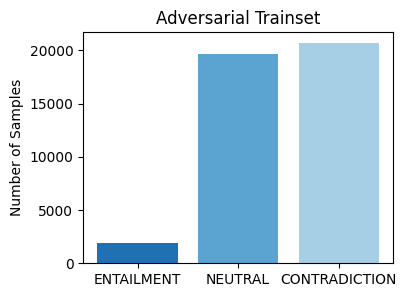

---


In [ ]:
# @title Labels Distribution

def labels_plotting(dataset, title):

  # data
  dataset = dataset["label"]
  df = pd.DataFrame(dataset, columns = ["label"])
  entailment = df.loc[df["label"] == "ENTAILMENT"].shape[0]
  neutral = df.loc[df["label"] == "NEUTRAL"].shape[0]
  contradiction = df.loc[df["label"] == "CONTRADICTION"].shape[0]
  data = [entailment, neutral, contradiction]
  print(title, ":", data)

  # settings
  fig, ax = plt.subplots(figsize=(4, 3))
  norm = plt.Normalize(min(data), max(data))
  colors = plt.cm.Blues(np.linspace(0.75, 0.35, 3))
  columns_names = ["ENTAILMENT", "NEUTRAL", "CONTRADICTION"]

  # plotting
  ax.bar(columns_names, data, color = colors)
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

  print("---")

###

labels_plotting(augmented_dataset, "Adversarial Trainset")

Full Trainset : [33000, 27310, 33000]


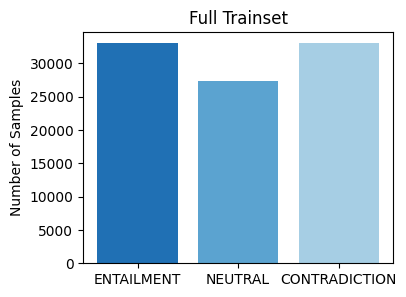

---


In [ ]:
# @title Labels Distribution

def labels_plotting(dataset1, dataset2, title):

  # data
  dataset1 = dataset1["label"]
  df1 = pd.DataFrame(dataset1, columns = ["label"])
  dataset2 = dataset2["label"]
  df2 = pd.DataFrame(dataset2, columns = ["label"])
  df = pd.concat((df1, df2))
  entailment = df.loc[df["label"] == "ENTAILMENT"].shape[0]
  neutral = df.loc[df["label"] == "NEUTRAL"].shape[0]
  contradiction = df.loc[df["label"] == "CONTRADICTION"].shape[0]
  data = [entailment, neutral, contradiction]
  print(title, ":", data)

  # settings
  fig, ax = plt.subplots(figsize=(4, 3))
  norm = plt.Normalize(min(data), max(data))
  colors = plt.cm.Blues(np.linspace(0.75, 0.35, 3))
  columns_names = ["ENTAILMENT", "NEUTRAL", "CONTRADICTION"]

  # plotting
  ax.bar(columns_names, data, color = colors)
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

  print("---")

###

labels_plotting(augmented_dataset, train_set, "Full Trainset")

Adversarial Trainset : [16656, 11400, 14168]


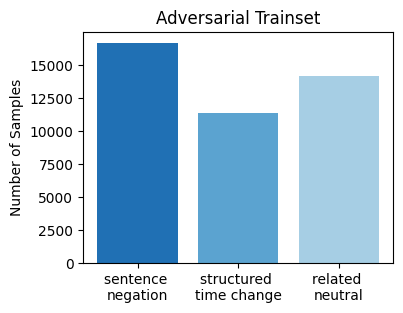

---


In [ ]:
# @title Strategy Distribution

def strategy_plotting(dataset, title):

  # data
  dataset = dataset["strategy"]
  df = pd.DataFrame(dataset, columns = ["strategy"])
  method1 = df.loc[df["strategy"] == "sentence negation"].shape[0]
  method2 = df.loc[df["strategy"] == "structured time change"].shape[0]
  method3 = df.loc[df["strategy"] == "related neutral"].shape[0]
  ...
  data = [method1, method2, method3]
  print(title, ":", data)

  # settings
  fig, ax = plt.subplots(figsize=(4, 3))
  norm = plt.Normalize(min(data), max(data))
  colors = plt.cm.Blues(np.linspace(0.75, 0.35, 3))
  columns_names = ["sentence \nnegation", "structured \ntime change", "related \nneutral"]

  # plotting
  ax.bar(columns_names, data, color = colors)
  ax.set_ylabel('Number of Samples')
  ax.set_title(title)
  plt.show()

  print("---")

###

strategy_plotting(augmented_dataset, "Adversarial Trainset")

In [ ]:
# !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# augmented_dataset.push_to_hub("Matteo-Pannacci/mnlp_adversarial_train_set")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/43 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Matteo-Pannacci/small_adversarial_train_set/commit/d5374242b869c7cd4159cfd1fed01b573ba03b73', commit_message='Upload dataset', commit_description='', oid='d5374242b869c7cd4159cfd1fed01b573ba03b73', pr_url=None, pr_revision=None, pr_num=None)